In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/pratical 2/training_set_pixel_size_and_HC.csv')
print("traing file")
print(train_df.info())
print("frist column")
print(train_df.head())

test_df = pd.read_csv('/content/drive/MyDrive/pratical 2/test_set_pixel_size.csv')
print("\n" + "="*50)
print("test file")
print(test_df.info())
print("frist column")
print(test_df.head())

traing file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 999 non-null    object 
 1   pixel size(mm)           999 non-null    float64
 2   head circumference (mm)  999 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.5+ KB
None
frist column
     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81

test file
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fil

In [7]:
base_path = '/content/drive/MyDrive/pratical 2'
train_img_dir = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/training_set')
csv_path = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/training_set_pixel_size_and_HC.csv')
train_csv = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/training_set_pixel_size_and_HC.csv')
test_csv = os.path.join(base_path, 'test_set_pixel_size.csv')
test_img_dir = os.path.join(base_path, '/content/drive/MyDrive/pratical 2/test_set')

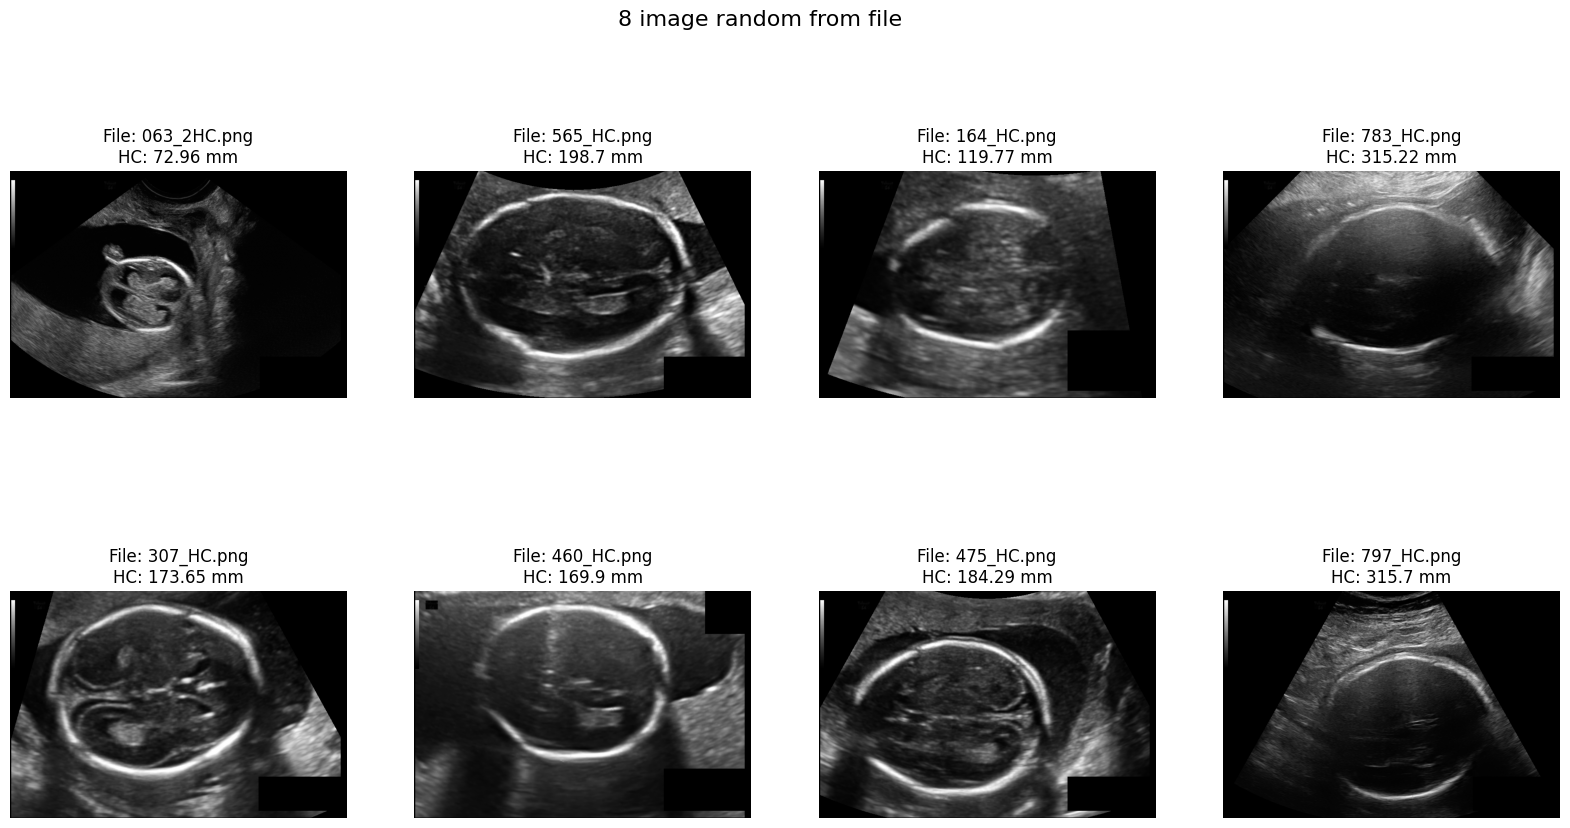

In [8]:
def show_training_samples(csv_path, img_dir, num_samples=8):
    df = pd.read_csv(csv_path)
    samples = df.sample(num_samples)

    plt.figure(figsize=(20, 10))
    plt.suptitle("8 image random from file", fontsize=16)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(img_dir, row['filename'])
        img = Image.open(img_path)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"File: {row['filename']}\nHC: {row['head circumference (mm)']} mm")
        plt.axis('off')
    plt.show()

#run
show_training_samples(train_csv, train_img_dir)

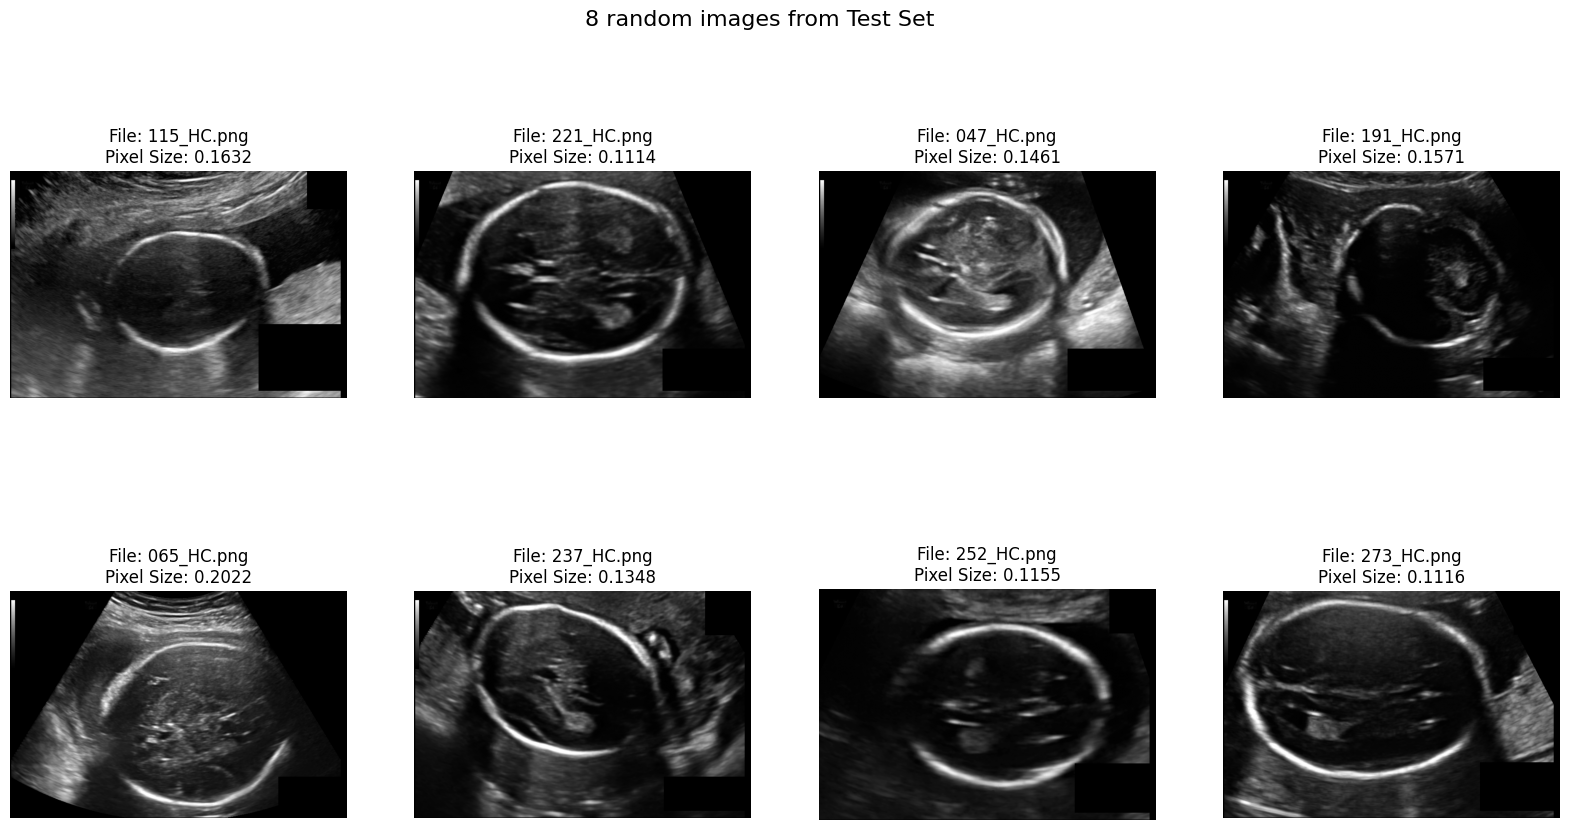

In [9]:
def show_test_samples(csv_path, img_dir, num_samples=8):
    df = pd.read_csv(csv_path)
    samples = df.sample(num_samples)

    plt.figure(figsize=(20, 10))
    plt.suptitle("8 random images from Test Set", fontsize=16)

    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(img_dir, row['filename'])
        img = Image.open(img_path)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"File: {row['filename']}\nPixel Size: {row['pixel size(mm)']:.4f}")
        plt.axis('off')
    plt.show()

# run again :D
show_test_samples(test_csv,test_img_dir)

In [ ]:
#Data pipeline

In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#elip algo
def extract_ellipse_params(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None: return [0]*5
    # find the white point in mask
    points = np.column_stack(np.where(mask > 0))
    if len(points) < 5: return [0]*5
    (y, x), (b, a), angle = cv2.fitEllipse(points)
    return [x, y, a, b, angle]

# Ramanujan
def calculate_hc_from_axes(a, b):
    a, b = a / 2, b / 2
    h = ((a - b)**2) / ((a + b)**2)
    circumference = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))
    return circumference

In [4]:
class HC18EllipseDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        # find file annotation
        anno_path = img_path.replace(".png", "_Annotation.png")

        image = Image.open(img_path).convert('L')
        orig_w, orig_h = image.size

        #label
        params = extract_ellipse_params(anno_path)

        # encoding
        label = np.array(params)
        label[0] /= orig_w  # center x
        label[1] /= orig_h  # center y
        label[2] /= orig_w  # big axis a
        label[3] /= orig_h  #small axisb b
        label[4] /= 360.0   # conner

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [ ]:
# 80 for tran and 20% for valid

In [ ]:
train_indices, val_indices = train_test_split(
    range(len(full_dataset)), test_size=0.2, random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# --- DATALOADER ---
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"NUmber of images for training: {len(train_dataset)}")
print(f"Number of images for testing: {len(val_dataset)}")

NUmber of images for training: 799
Number of images for testing: 200


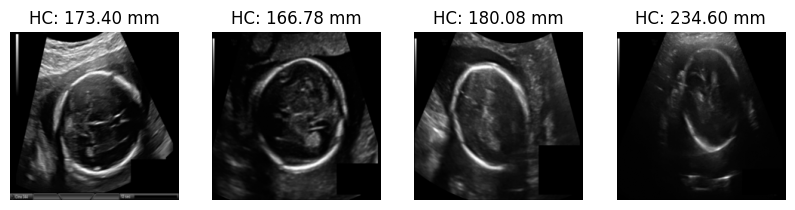

In [ ]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"HC: {labels[i].item():.2f} mm")
    plt.axis('off')
plt.show()

In [ ]:
#check sample
image, label = full_dataset[0]
print(f"frist sample: {label.item()} mm")

frist sample: 44.29999923706055 mm


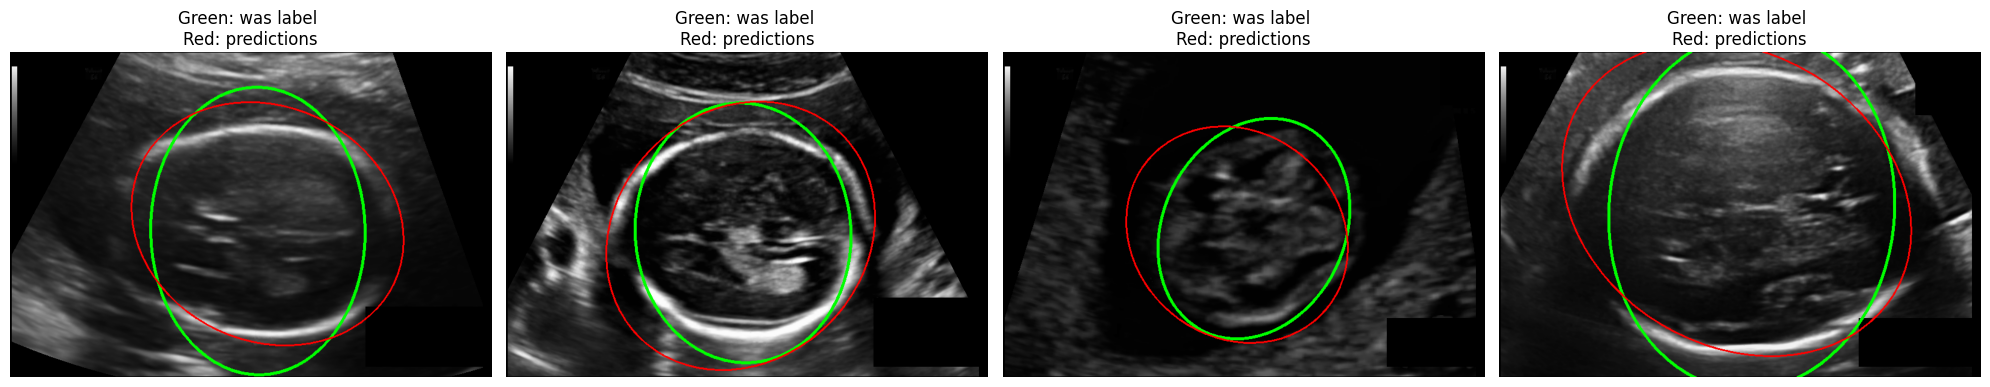

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_comparison(model, dataset, device, num_samples=4):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    plt.figure(figsize=(20, 10))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            filename = dataset.df.iloc[idx, 0]
            img_path = os.path.join(dataset.img_dir, filename)
            anno_path = img_path.replace(".png", "_Annotation.png")

            img_bgr = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            h, w, _ = img_rgb.shape

            gt_params = extract_ellipse_params(anno_path)

            image_tensor, _ = dataset[idx]
            pred_params = model(image_tensor.unsqueeze(0).to(device)).cpu().numpy()[0]

            p_x, p_y = pred_params[0] * w, pred_params[1] * h
            p_a, p_b = pred_params[2] * w, pred_params[3] * h
            p_angle = pred_params[4] * 360

            cv2.ellipse(img_rgb, (int(gt_params[0]), int(gt_params[1])),
                        (int(gt_params[3]/2), int(gt_params[2]/2)),
                        int(gt_params[4]), 0, 360, (0, 255, 0), 3)

            cv2.ellipse(img_rgb, (int(p_x), int(p_y)),
                        (int(p_a/2), int(p_b/2)),
                        int(p_angle), 0, 360, (255, 0, 0), 2)

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img_rgb)
            plt.title(f"Green: was label \nRed: predictions")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_comparison(model, full_dataset, device)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity
        return self.relu(out)

In [10]:
class ResNet50_Ellipse_finetune(nn.Module):
    def __init__(self, block, layers):
        super(ResNet50_Ellipse_finetune, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, 5)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion))
        layers = [block(self.in_planes, planes, stride, downsample)]
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks): layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))
        x = self.layer4(self.layer3(self.layer2(self.layer1(x))))
        x = torch.flatten(self.avgpool(x), 1)
        return self.fc(x)

In [11]:
base_path = '/content/drive/MyDrive/pratical 2'
train_img_dir = os.path.join(base_path, 'training_set')
train_csv = os.path.join(base_path, 'training_set_pixel_size_and_HC.csv')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50_Ellipse_finetune(Bottleneck, [3, 4, 6, 3]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [12]:
full_dataset = HC18EllipseDataset(train_csv, train_img_dir, transform=data_transform)
train_idx, val_idx = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=32, shuffle=False)

In [13]:
train_mae_history = []
val_mae_history = []

def calculate_mae_during_train(model, loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            preds = model(imgs).cpu().numpy()
            targets = labels.numpy()

            for i in range(len(preds)):
                p_a, p_b = preds[i][2] * 800, preds[i][3] * 540
                t_a, t_b = targets[i][2] * 800, targets[i][3] * 540

                p_hc = calculate_hc_from_axes(p_a, p_b)
                t_hc = calculate_hc_from_axes(t_a, t_b)

                errors.append(abs(p_hc - t_hc))
    return np.mean(errors)

def train_ellipse_model(model, train_loader, val_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(imgs), labels)
            loss.backward()
            optimizer.step()

        t_mae = calculate_mae_during_train(model, train_loader)
        v_mae = calculate_mae_during_train(model, val_loader)

        train_mae_history.append(t_mae)
        val_mae_history.append(v_mae)

        print(f"Epoch {epoch+1}/{epochs} - Train MAE: {t_mae:.2f}mm - Val MAE: {v_mae:.2f}mm")

train_ellipse_model(model, train_loader, val_loader, epochs=20)

Epoch 1/20 - Train MAE: 250.96mm - Val MAE: 256.84mm
Epoch 2/20 - Train MAE: 238.55mm - Val MAE: 251.26mm
Epoch 3/20 - Train MAE: 136.81mm - Val MAE: 170.93mm
Epoch 4/20 - Train MAE: 121.73mm - Val MAE: 149.30mm
Epoch 5/20 - Train MAE: 119.85mm - Val MAE: 162.11mm
Epoch 6/20 - Train MAE: 165.47mm - Val MAE: 183.55mm
Epoch 7/20 - Train MAE: 83.99mm - Val MAE: 115.27mm
Epoch 8/20 - Train MAE: 115.24mm - Val MAE: 150.98mm
Epoch 9/20 - Train MAE: 122.34mm - Val MAE: 154.32mm
Epoch 10/20 - Train MAE: 74.91mm - Val MAE: 126.55mm
Epoch 11/20 - Train MAE: 59.09mm - Val MAE: 116.52mm
Epoch 12/20 - Train MAE: 62.74mm - Val MAE: 116.75mm
Epoch 13/20 - Train MAE: 64.76mm - Val MAE: 118.55mm
Epoch 14/20 - Train MAE: 62.15mm - Val MAE: 115.79mm
Epoch 15/20 - Train MAE: 54.94mm - Val MAE: 108.14mm
Epoch 16/20 - Train MAE: 105.95mm - Val MAE: 148.15mm
Epoch 17/20 - Train MAE: 62.75mm - Val MAE: 121.71mm
Epoch 18/20 - Train MAE: 49.04mm - Val MAE: 112.10mm
Epoch 19/20 - Train MAE: 47.64mm - Val MAE: 11

In [14]:
from torch.utils.data import Subset
try:
    val_dataset = Subset(full_dataset, val_indices)
except NameError:
    from sklearn.model_selection import train_test_split
    train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
    val_dataset = Subset(full_dataset, val_indices)

print(f"val_dataset is define with {len(val_dataset)} sample.")

val_dataset is define with 200 sample.


In [15]:
def get_final_predictions(model, test_csv_path, test_img_dir):
    test_df = pd.read_csv(test_csv_path)
    model.eval()
    final_hcs = []

    with torch.no_grad():
        for _, row in test_df.iterrows():
            img_path = os.path.join(test_img_dir, row['filename'])
            pixel_size = row['pixel size(mm)']
            raw_img = Image.open(img_path).convert('L')
            orig_w, orig_h = raw_img.size

         #predict
            img_t = data_transform(raw_img).unsqueeze(0).to(device)
            pred = model(img_t).cpu().numpy()[0]
            pred_a = pred[2] * orig_w
            pred_b = pred[3] * orig_h

            # Cal circum
            hc_pixel = calculate_hc_from_axes(pred_a, pred_b)
            hc_mm = hc_pixel * pixel_size

            final_hcs.append([row['filename'], hc_mm])

    return pd.DataFrame(final_hcs, columns=['filename', 'predicted_hc_mm'])


In [16]:
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(
    range(len(full_dataset)), test_size=0.2, random_state=42
)

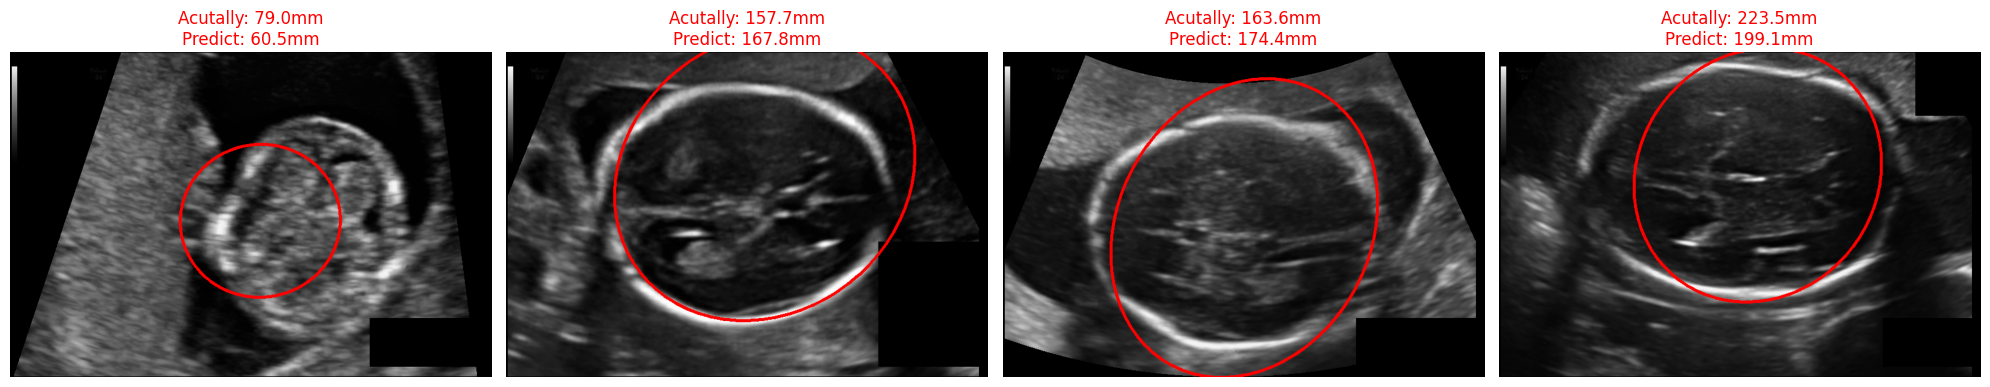

In [17]:
import cv2
import matplotlib.pyplot as plt

def visualize_ellipse_results(model, dataset, indices, device, num_samples=4):
    model.eval()
    plt.figure(figsize=(20, 10))
    selected_indices = np.random.choice(indices, num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(selected_indices):
            filename = dataset.df.iloc[idx, 0]
            pixel_size = dataset.df.iloc[idx, 1]
            actual_hc = dataset.df.iloc[idx, 2]

            img_path = os.path.join(dataset.img_dir, filename)
            raw_img = cv2.imread(img_path)
            raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
            h, w, _ = raw_img.shape

            # predicy by model
            image_tensor, _ = dataset[idx]
            pred = model(image_tensor.unsqueeze(0).to(device)).cpu().numpy()[0]

            x = pred[0] * w
            y = pred[1] * h
            a = pred[2] * w
            b = pred[3] * h
            angle = pred[4] * 360

            hc_pixel = calculate_hc_from_axes(a, b)
            hc_mm = hc_pixel * pixel_size
            cv2.ellipse(raw_img, (int(x), int(y)), (int(a/2), int(b/2)),
                        int(angle), 0, 360, (255, 0, 0), 3)

            # plot the image
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(raw_img)
            plt.title(f"Acutally: {actual_hc:.1f}mm\nPredict: {hc_mm:.1f}mm", color='red')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
visualize_ellipse_results(model, full_dataset, val_indices, device)

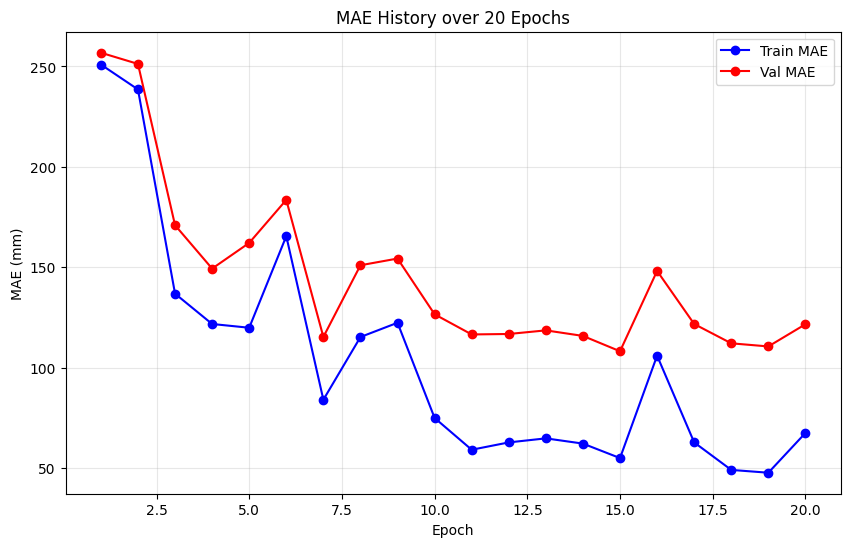

In [22]:
def plot_mae_history(train_history, val_history):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_history) + 1), train_history, marker='o', color='blue', label='Train MAE')
    plt.plot(range(1, len(val_history) + 1), val_history, marker='o', color='red', label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE (mm)')
    plt.title('MAE History over 20 Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_mae_history(train_mae_history, val_mae_history)

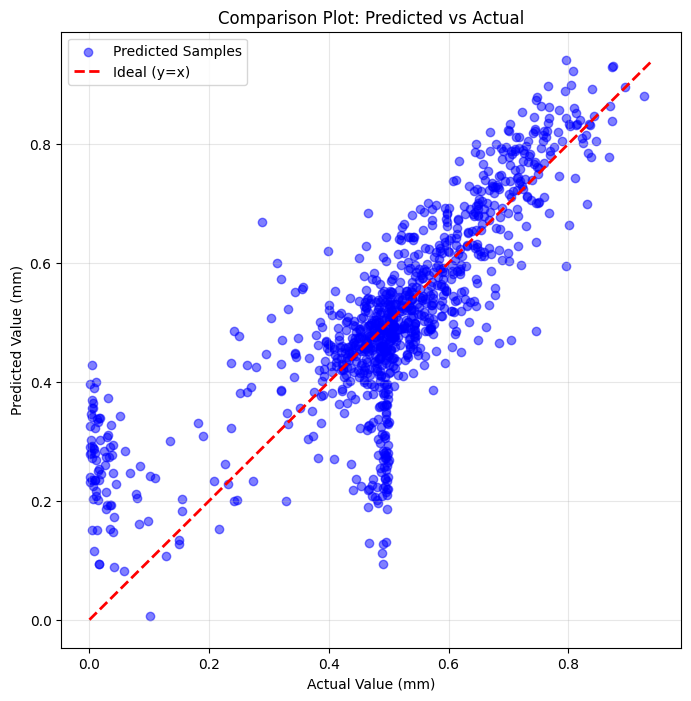

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            out = model(imgs.to(device))
            preds.extend(out.cpu().numpy().flatten())
            targets.extend(lbls.numpy().flatten())

    plt.figure(figsize=(8, 8))
    plt.scatter(targets, preds, color='blue', alpha=0.5, label='Predicted Samples')

    limit = max(max(preds), max(targets))
    plt.plot([0, limit], [0, limit], color='red', linestyle='--', linewidth=2, label='Ideal (y=x)')

    plt.xlabel('Actual Value (mm)')
    plt.ylabel('Predicted Value (mm)')
    plt.title('Comparison Plot: Predicted vs Actual')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_scatter(model, val_loader)